In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
import math
import string
import gc
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from datetime import datetime
from textblob import TextBlob
from text_processing import clean

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christineibaraki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/christineibaraki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christineibaraki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
posts_pkl_path = os.path.join('..', '..', "combined_bigquery_processed.pkl")
posts_df = pd.read_pickle(posts_pkl_path)

In [3]:
# this will take 1-2 minutes
# posts_file_path = os.path.join('..', 'data', 'raw', "combined_bigquery_processed.csv")
# posts_df = pd.read_csv(posts_file_path)

In [4]:
# should have 10,015,586 rows
print(f"number of rows in data: {len(posts_df)}")

number of rows in data: 10015586


In [5]:
pd.set_option('display.max_columns', None)
posts_df.head()

,selftext,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class,created_date,post_type
0,"Another one of their smug, preachy ass headlin...",NaN,NaN,NaN,ThisIsTedSpeaking,GA,NaN,1548979405,t5_38unr,t3_alr7qq,t3_alr7qq,3,1552341042,0,0,efhd3oz,The_Donald,NaN,NaN,georgia-us-state,2019-01-31,extant
1,enema has been pretending to be a rapper for y...,NaN,NaN,NaN,mastermeatlock,VA,NaN,1549238712,t5_38unr,t3_amv0ki,t3_amv0ki,9,1553492656,0,0,efownuo,The_Donald,NaN,NaN,virginia,2019-02-03,extant
2,That area from Abilene to border (I-20 to I-10...,NaN,NaN,NaN,txladyvoter,#45,NaN,1549238721,t5_38unr,t3_amr6kj,t1_efo6zai,3,1553492661,0,0,efowo8r,The_Donald,NaN,NaN,MURICA,2019-02-03,extant
3,She's got the politician fist point down,NaN,NaN,NaN,Tdaccount841,SC,NaN,1549152215,t5_38unr,t3_amjtig,t3_amjtig,1,1553452149,0,0,efmhy5u,The_Donald,NaN,NaN,south-carolina,2019-02-02,extant
4,Imagine getting paid to drop three words on a ...,NaN,NaN,NaN,Ask_If_Im_A_Cactus,Кактус,NaN,1549756908,t5_38unr,t3_aoy05c,t3_aoy05c,4,1553983794,0,0,eg4fg9x,The_Donald,NaN,NaN,ivanka,2019-02-09,extant


In [6]:
posts_df.describe()

,score_hidden,name,downs,created_utc,score,retrieved_on,controversiality,gilded,ups
count,0.0,0.0,0.0,1.001559e+07,1.001559e+07,1.001559e+07,1.001559e+07,1.001559e+07,0.0
mean,NaN,NaN,NaN,1.561263e+09,8.982444e+00,1.567742e+09,8.746368e-03,6.030601e-05,NaN
std,NaN,NaN,NaN,9.027785e+06,3.201599e+01,1.113914e+07,9.311214e-02,8.383723e-03,NaN
min,NaN,NaN,NaN,1.546301e+09,-8.200000e+02,1.550713e+09,0.000000e+00,0.000000e+00,NaN
25%,NaN,NaN,NaN,1.553330e+09,1.000000e+00,1.556517e+09,0.000000e+00,0.000000e+00,NaN
50%,NaN,NaN,NaN,1.561057e+09,3.000000e+00,1.570363e+09,0.000000e+00,0.000000e+00,NaN
75%,NaN,NaN,NaN,1.569009e+09,7.000000e+00,1.577285e+09,0.000000e+00,0.000000e+00,NaN
max,NaN,NaN,NaN,1.577837e+09,5.340000e+03,1.586450e+09,1.000000e+00,8.000000e+00,NaN


In [7]:
posts_df.groupby('post_type')['post_type'].count() #majority are either removed or blank... need to investigate this for sure

post_type
blank          897
deleted     536690
extant     8983413
removed     494586
Name: post_type, dtype: int64

In [8]:
posts_by_date = posts_df.groupby('created_date')['post_type'].value_counts().unstack()
posts_by_date.fillna(0, inplace=True)
posts_by_date.head()

post_type,blank,deleted,extant,removed
created_date,,,,
2018-12-31,0.0,322.0,5272.0,191.0
2019-01-01,0.0,1040.0,18630.0,888.0
2019-01-02,0.0,1223.0,20986.0,946.0
2019-01-03,1.0,1356.0,24190.0,1050.0
2019-01-04,1.0,1695.0,28213.0,1343.0


<AxesSubplot:xlabel='created_date'>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


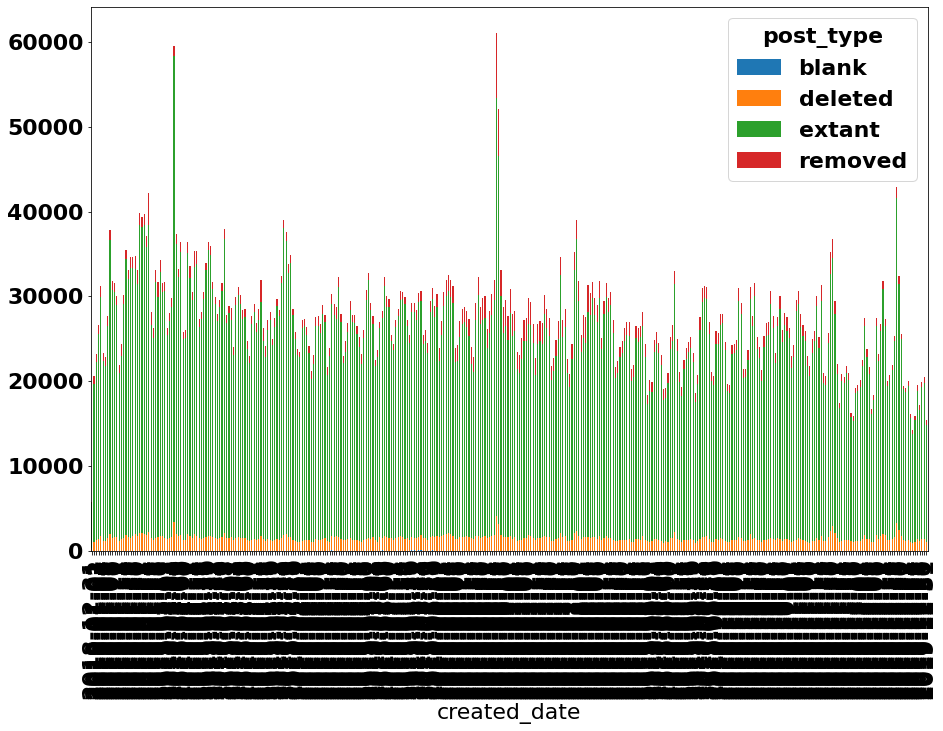

In [9]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = (15,10)

posts_by_date.plot(kind='bar', stacked=True)

# Create data set for analysis

In [10]:
print(posts_df.created_date.min())
print(posts_df.created_date.max())

2018-12-31
2019-12-31


In [11]:
# sample
posts_df = posts_df.sample(frac=0.001, replace=False)
print(f"num rows in sample {len(posts_df)}")
print(posts_df.created_date.min())
print(posts_df.created_date.max())

num rows in sample 10016
2018-12-31
2019-12-31


In [12]:
extant_posts = posts_df[posts_df['post_type'] == 'extant']
print(f"nrow in extant posts: {len(extant_posts)}")
# 8,983,413
extant_posts.head()

nrow in extant posts: 9019


,selftext,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class,created_date,post_type
7031695,Objects in MAGA are closer than they appear.,NaN,NaN,NaN,fuqdupd,NaN,NaN,1568085219,t5_38unr,t3_d1zp4n,t1_ezs7dra,24,1576582523,0,0,ezs9d53,The_Donald,NaN,NaN,NaN,2019-09-09,extant
9475418,I’m so fucking sick of State elected represent...,NaN,NaN,NaN,ManRAh,NaN,NaN,1571684528,t5_38unr,t3_dkzfnt,t3_dkzfnt,5,1579650916,0,0,f4n0xj6,The_Donald,NaN,NaN,NaN,2019-10-21,extant
2989683,Help us /pol. You’re our only hope!,NaN,NaN,NaN,sherlockHolmes012,NaN,NaN,1562021656,t5_38unr,t3_c813et,t3_c813et,26,1571221727,0,0,esiwni1,The_Donald,NaN,NaN,NaN,2019-07-01,extant
2885426,There's nothing wrong with this rule and it's ...,NaN,NaN,NaN,BrassBelles,NaN,NaN,1563132314,t5_38unr,t3_cd1eyh,t3_cd1eyh,1,1572004436,0,0,etryuwe,The_Donald,NaN,NaN,NaN,2019-07-14,extant
8669271,you mean the Mexican made cars,NaN,NaN,NaN,SirCarlWinslow,NaN,NaN,1573970802,t5_38unr,t3_dxh7wy,t1_f7q8uyj,1,1581990184,0,0,f7qwl1x,The_Donald,NaN,NaN,NaN,2019-11-17,extant


In [13]:
# remove unnecesary large data obj, since we have extant_posts
del posts_df
gc.collect()

155

### Review text

In [14]:
extant_posts['selftext'].head(15)

7031695         Objects in MAGA are closer than they appear.
9475418    I’m so fucking sick of State elected represent...
2989683                  Help us /pol. You’re our only hope!
2885426    There's nothing wrong with this rule and it's ...
8669271                       you mean the Mexican made cars
5549046    Credits transfer. It's not an all or nothing s...
1621184              Blowjobs only is also an option.  Cunt.
3011485    “But muh illegal aliens are being mistreated!”...
4120232              Cant have gays without straight people.
3627108                                                 Amen
5393152    Well Aristotle, show me where the Constitution...
5428151    This is why the Democrats and the DNC should p...
2010521    **OFFICIAL THE DONALD BACKUP: https://thedonal...
6124821    Elected to high government positions for the DNC.
3624145    CNN: "Here's why freezing accounts of human tr...
Name: selftext, dtype: object

## Tokenize and clean

In [15]:
def process_text(doc):
    
    text_clean_space = clean.remove_multiple_spaces(doc)
    text_clean_space = ''.join(
        filter(lambda x: x in clean.printable, text_clean_space))
    strip_punc_lower = text_clean_space.translate(
            str.maketrans('', '', string.punctuation)).lower()
    len_clean_str = len(strip_punc_lower)
    tokens = []
    clean_tokens = []
    lemmatized_tokens = []
    bigrams = []
    trigrams = []
    try: 
        token_list = word_tokenize(strip_punc_lower)
        for token in word_tokenize(strip_punc_lower):
            tokens.append(token)
            if token not in clean.stop_words and len(token)>1:
                clean_tokens.append(token)
                lemmatized_tokens.append(clean.wnl.lemmatize(token))
        
        bigrams = list(nltk.bigrams(lemmatized_tokens))
        trigrams = list(nltk.trigrams(lemmatized_tokens))

    except Exception as e:
        print(e)
        
    return (text_clean_space,
            strip_punc_lower,
            len_clean_str,
            tokens,
            clean_tokens,
            lemmatized_tokens,
            bigrams,
            trigrams)

In [16]:
processed_text_columns = extant_posts.apply(
    lambda row: process_text(row['selftext']), axis='columns', result_type='expand')

In [17]:
processed_text_columns.columns = ['text_clean_space',
                                  'text_clean_punc_lower',
                                  'len_clean',
                                  'tokens',
                                  'tokens_clean',
                                  'tokens_lemma',
                                  'bigrams',
                                  'trigrams']

In [18]:
processed_text_columns.head(20)

,text_clean_space,text_clean_punc_lower,len_clean,tokens,tokens_clean,tokens_lemma,bigrams,trigrams
7031695,Objects in MAGA are closer than they appear.,objects in maga are closer than they appear,43,"[objects, in, maga, are, closer, than, they, a...","[objects, maga, closer, appear]","[object, maga, closer, appear]","[(object, maga), (maga, closer), (closer, appe...","[(object, maga, closer), (maga, closer, appear)]"
9475418,Im so fucking sick of State elected representa...,im so fucking sick of state elected representa...,154,"[im, so, fucking, sick, of, state, elected, re...","[im, fucking, sick, state, elected, representa...","[im, fucking, sick, state, elected, representa...","[(im, fucking), (fucking, sick), (sick, state)...","[(im, fucking, sick), (fucking, sick, state), ..."
2989683,Help us /pol. Youre our only hope!,help us pol youre our only hope,31,"[help, us, pol, youre, our, only, hope]","[help, us, pol, hope]","[help, u, pol, hope]","[(help, u), (u, pol), (pol, hope)]","[(help, u, pol), (u, pol, hope)]"
2885426,There's nothing wrong with this rule and it's ...,theres nothing wrong with this rule and its no...,247,"[theres, nothing, wrong, with, this, rule, and...","[theres, nothing, wrong, rule, sexist, actuall...","[there, nothing, wrong, rule, sexist, actually...","[(there, nothing), (nothing, wrong), (wrong, r...","[(there, nothing, wrong), (nothing, wrong, rul..."
8669271,you mean the Mexican made cars,you mean the mexican made cars,30,"[you, mean, the, mexican, made, cars]","[mean, mexican, made, cars]","[mean, mexican, made, car]","[(mean, mexican), (mexican, made), (made, car)]","[(mean, mexican, made), (mexican, made, car)]"
5549046,Credits transfer. It's not an all or nothing s...,credits transfer its not an all or nothing sit...,654,"[credits, transfer, its, not, an, all, or, not...","[credits, transfer, nothing, situation, think,...","[credit, transfer, nothing, situation, think, ...","[(credit, transfer), (transfer, nothing), (not...","[(credit, transfer, nothing), (transfer, nothi..."
1621184,Blowjobs only is also an option. Cunt.,blowjobs only is also an option cunt,36,"[blowjobs, only, is, also, an, option, cunt]","[blowjobs, also, option, cunt]","[blowjob, also, option, cunt]","[(blowjob, also), (also, option), (option, cunt)]","[(blowjob, also, option), (also, option, cunt)]"
3011485,But muh illegal aliens are being mistreated! O...,but muh illegal aliens are being mistreated ok...,316,"[but, muh, illegal, aliens, are, being, mistre...","[muh, illegal, aliens, mistreated, ok, introdu...","[muh, illegal, alien, mistreated, ok, introduc...","[(muh, illegal), (illegal, alien), (alien, mis...","[(muh, illegal, alien), (illegal, alien, mistr..."
4120232,Cant have gays without straight people.,cant have gays without straight people,38,"[cant, have, gays, without, straight, people]","[cant, gays, without, straight, people]","[cant, gay, without, straight, people]","[(cant, gay), (gay, without), (without, straig...","[(cant, gay, without), (gay, without, straight..."
3627108,Amen,amen,4,[amen],[amen],[amen],[],[]


In [19]:
extant_posts = pd.concat([extant_posts, processed_text_columns],
                         axis='columns')

In [20]:
extant_posts.head()

,selftext,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class,created_date,post_type,text_clean_space,text_clean_punc_lower,len_clean,tokens,tokens_clean,tokens_lemma,bigrams,trigrams
7031695,Objects in MAGA are closer than they appear.,NaN,NaN,NaN,fuqdupd,NaN,NaN,1568085219,t5_38unr,t3_d1zp4n,t1_ezs7dra,24,1576582523,0,0,ezs9d53,The_Donald,NaN,NaN,NaN,2019-09-09,extant,Objects in MAGA are closer than they appear.,objects in maga are closer than they appear,43,"[objects, in, maga, are, closer, than, they, a...","[objects, maga, closer, appear]","[object, maga, closer, appear]","[(object, maga), (maga, closer), (closer, appe...","[(object, maga, closer), (maga, closer, appear)]"
9475418,I’m so fucking sick of State elected represent...,NaN,NaN,NaN,ManRAh,NaN,NaN,1571684528,t5_38unr,t3_dkzfnt,t3_dkzfnt,5,1579650916,0,0,f4n0xj6,The_Donald,NaN,NaN,NaN,2019-10-21,extant,Im so fucking sick of State elected representa...,im so fucking sick of state elected representa...,154,"[im, so, fucking, sick, of, state, elected, re...","[im, fucking, sick, state, elected, representa...","[im, fucking, sick, state, elected, representa...","[(im, fucking), (fucking, sick), (sick, state)...","[(im, fucking, sick), (fucking, sick, state), ..."
2989683,Help us /pol. You’re our only hope!,NaN,NaN,NaN,sherlockHolmes012,NaN,NaN,1562021656,t5_38unr,t3_c813et,t3_c813et,26,1571221727,0,0,esiwni1,The_Donald,NaN,NaN,NaN,2019-07-01,extant,Help us /pol. Youre our only hope!,help us pol youre our only hope,31,"[help, us, pol, youre, our, only, hope]","[help, us, pol, hope]","[help, u, pol, hope]","[(help, u), (u, pol), (pol, hope)]","[(help, u, pol), (u, pol, hope)]"
2885426,There's nothing wrong with this rule and it's ...,NaN,NaN,NaN,BrassBelles,NaN,NaN,1563132314,t5_38unr,t3_cd1eyh,t3_cd1eyh,1,1572004436,0,0,etryuwe,The_Donald,NaN,NaN,NaN,2019-07-14,extant,There's nothing wrong with this rule and it's ...,theres nothing wrong with this rule and its no...,247,"[theres, nothing, wrong, with, this, rule, and...","[theres, nothing, wrong, rule, sexist, actuall...","[there, nothing, wrong, rule, sexist, actually...","[(there, nothing), (nothing, wrong), (wrong, r...","[(there, nothing, wrong), (nothing, wrong, rul..."
8669271,you mean the Mexican made cars,NaN,NaN,NaN,SirCarlWinslow,NaN,NaN,1573970802,t5_38unr,t3_dxh7wy,t1_f7q8uyj,1,1581990184,0,0,f7qwl1x,The_Donald,NaN,NaN,NaN,2019-11-17,extant,you mean the Mexican made cars,you mean the mexican made cars,30,"[you, mean, the, mexican, made, cars]","[mean, mexican, made, cars]","[mean, mexican, made, car]","[(mean, mexican), (mexican, made), (made, car)]","[(mean, mexican, made), (mexican, made, car)]"


Text(0, 0.5, 'Frequency')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


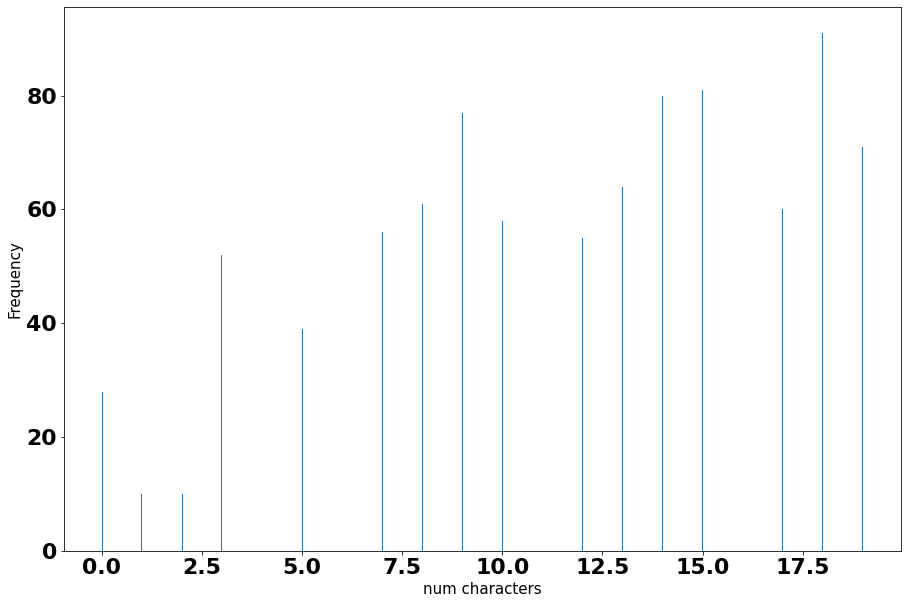

In [21]:
extant_posts['len_clean'][extant_posts['len_clean']<20].hist(
    bins=1000,grid=False)
plt.xlabel("num characters", fontsize=15)
plt.ylabel("Frequency",fontsize=15)

Text(0, 0.5, 'Frequency')

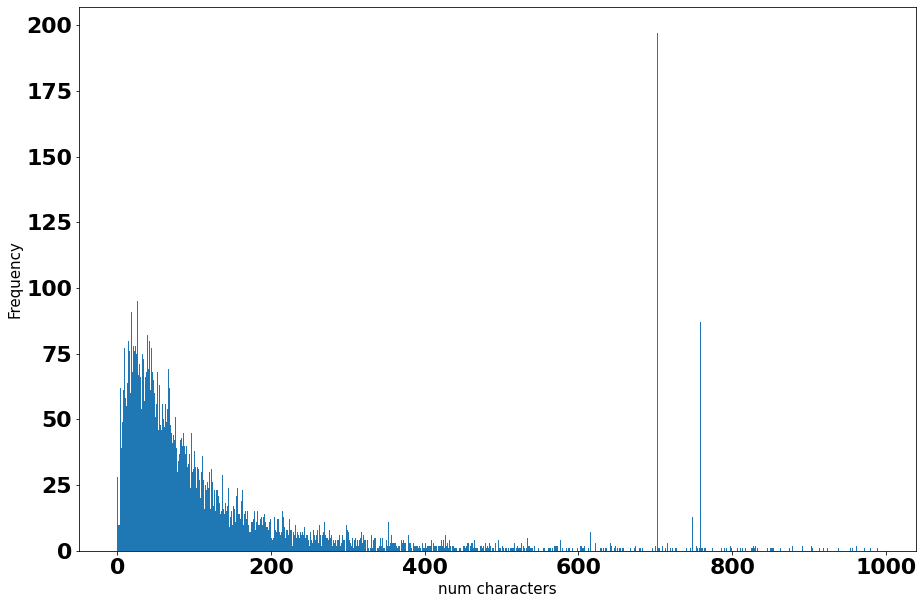

In [22]:
extant_posts['len_clean'][extant_posts['len_clean']<1000].hist(
    bins=1000,grid=False)
plt.xlabel("num characters", fontsize=15)
plt.ylabel("Frequency",fontsize=15)

In [23]:
print(extant_posts.shape)

(9019, 30)


In [24]:
extant_posts.to_pickle("../../extant_posts_processed.pkl")